Load MNIST Dataset

In [37]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
# Define a transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

469 Training Samples.


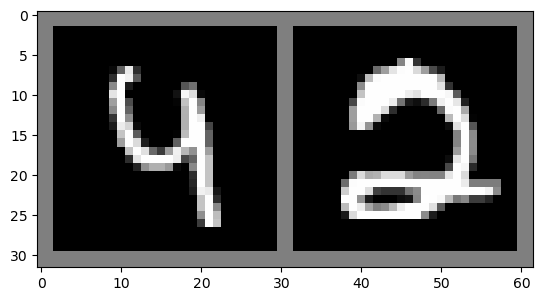

In [132]:

# Define the data loaders
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

print(len(trainloader), "Training Samples.")


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define a function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show a couple of training images
imshow(torchvision.utils.make_grid(images[:2]))

Define Encoder NN

In [133]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, num_labels):
        super(Encoder, self).__init__()
        self.num_labels = num_labels
        self.conv1 = nn.Conv2d(input_dim + num_labels, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(hidden_dim * 7 * 7, z_dim)
        self.fc2 = nn.Linear(hidden_dim * 7 * 7, z_dim)
        
    def forward(self, x, y):
        y_onehot = torch.zeros(y.size(0), self.num_labels, x.shape[2], x.shape[3], device=x.device)
        y_onehot.scatter_(1, y.unsqueeze(1).unsqueeze(-1).unsqueeze(-1), 1)
        x = torch.cat([x, y_onehot], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        return mu, logvar


Define Decoder NN

In [134]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim, num_labels):
        super(Decoder, self).__init__()
        self.num_labels = num_labels
        self.fc = nn.Linear(z_dim + num_labels, hidden_dim * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, z, y):
        y = y.view(-1, 1).repeat(1, self.num_labels)  # Add this line to reshape the labels tensor
        z = torch.cat([z, y], dim=1)
        x = F.relu(self.fc(z))
        x = x.view(-1, self.deconv1.in_channels, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        x = torch.sigmoid(x)
        return x

Define VAE

In [135]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, output_dim, num_labels):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.num_labels = num_labels
        self.encoder = Encoder(input_dim, hidden_dim, z_dim, num_labels)
        self.decoder = Decoder(z_dim, hidden_dim, output_dim, num_labels)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, y)
        return x_recon, mu, logvar

    def vae_loss(self, x_recon, x, mu, logvar, kl_weight):
        # Reconstruction loss
        recon_loss = F.mse_loss(x_recon, x, reduction='sum')

        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        total_loss = recon_loss + kl_weight * kl_loss

        return total_loss, recon_loss, kl_loss

Train VAE

In [138]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")
    print(torch.__version__)
    device = torch.device("cpu")


# Define the hyperparameters
input_dim = 1
hidden_dim = 32
z_dim = 20
output_dim = 1
num_labels = 10
num_epochs = 10
learning_rate = 1e-3
kl_weight = 0.1

# Create the VAE model
vae = VAE(input_dim, hidden_dim, z_dim, output_dim, num_labels).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Define the training loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    for batch_idx, (data, labels) in enumerate(trainloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        recon_data, mu, logvar = vae(data, labels)
        loss, recon_loss, kl_loss = vae.vae_loss(recon_data, data, mu, logvar, kl_weight)
        loss.backward()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRecon Loss: {:.6f}\tKL Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item() / len(data),
                recon_loss.item() / len(data),
                kl_loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f} Average Recon Loss: {:.4f} Average KL Loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset),
          train_recon_loss / len(trainloader.dataset),
          train_kl_loss / len(trainloader.dataset)))


CUDA is available!
GPU: NVIDIA GeForce GTX 1080 Ti
Epoch: 0 [0/60000 (0%)]	Loss: 1684.745361	Recon Loss: 1684.743774	KL Loss: 0.016432
Epoch: 0 [12800/60000 (21%)]	Loss: 727.762085	Recon Loss: 726.878418	KL Loss: 8.836498


KeyboardInterrupt: 

Print Example Results

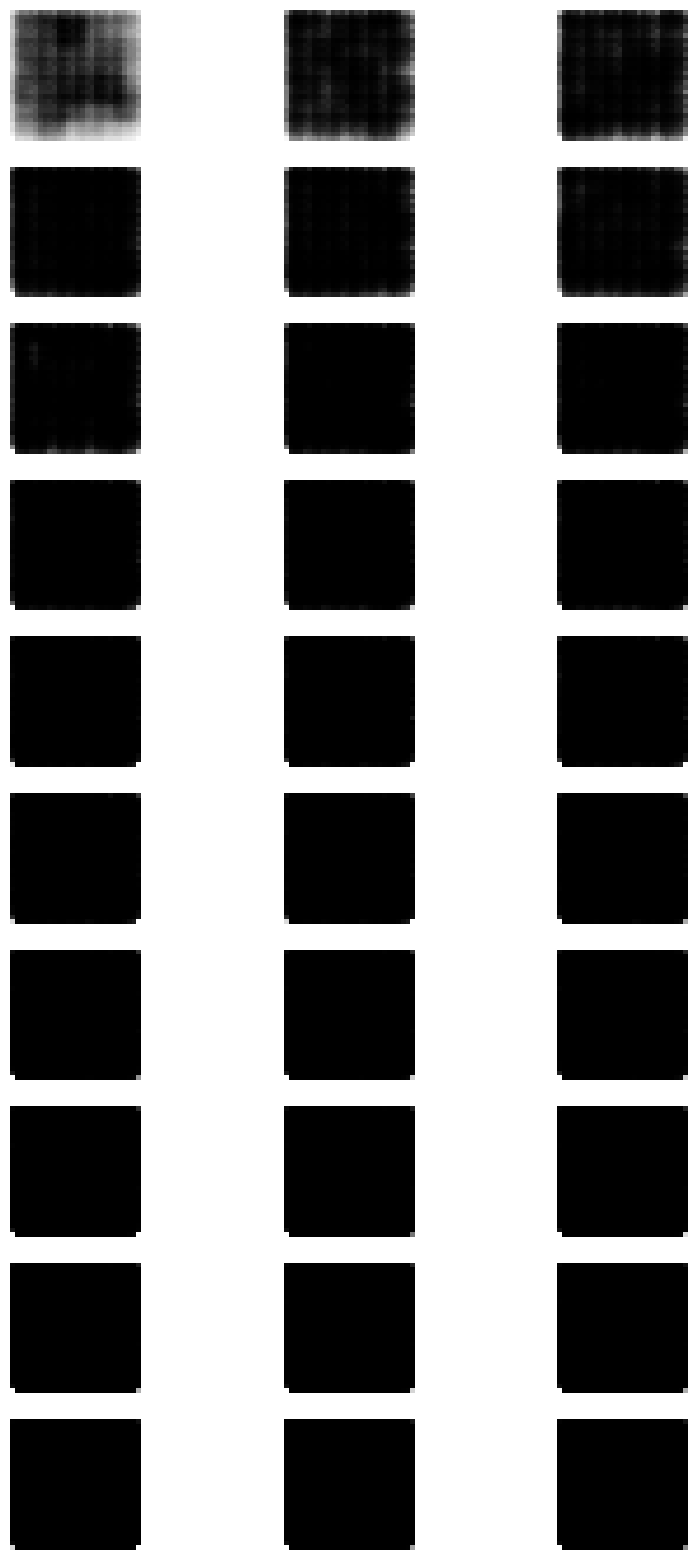

In [139]:
import matplotlib.pyplot as plt

vae.eval()
num_examples = 30  # 3 examples of each digit
num_digits = 10
fig, axes = plt.subplots(nrows=num_digits, ncols=3, figsize=(10, 20), sharex=True, sharey=True)

for digit in range(num_digits):
    for i in range(3):
        z_sample = torch.randn(1, z_dim).to(device)
        label = torch.tensor([digit], dtype=torch.long).to(device)
        with torch.no_grad():
            generated_image = vae.decoder(z_sample, label)
        generated_image = generated_image.cpu().numpy()  # Transfer the tensor to the CPU and convert it to a NumPy array
        axes[digit, i].imshow(generated_image.reshape(28, 28), cmap='gray')
        axes[digit, i].axis('off')

plt.show()


Evaluate Results using Fréchet Inception Distance (FID) and Structural Similarity Index (SSIM) Learned Perceptual Image Patch Similarity (LPIPS)

In [13]:
# TODO

Load CelebA Dataset

In [14]:
# TODO

Train VAE on CelebA Dataset

In [15]:
# TODO

Print Example Results

In [16]:
# TODO

Evaluate Results using Fréchet Inception Distance (FID) and Structural Similarity Index (SSIM) Learned Perceptual Image Patch Similarity (LPIPS)

In [17]:
# TODO

Maybe compare to other models?

In [18]:
# TODO